In [ ]:
#calculate mIoU, per class IoU, and Dice for each image
#record results
#merge results with other info (lat, lon, storm, date, etc.)

In [1]:
#load up the basics
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import TF stuff
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.9.1
 GPU: /device:GPU:0


In [2]:
#Load in DF
doodlecsvpath = '../data/DoodleManifestOct5_22.csv'
doodlecsv = pd.read_csv(doodlecsvpath)
doodlecsv.head()

,doodled_image,imageP,image,Filename,storm_id,archive,date,ul_lat,ul_lon,ll_lat,ll_lon,ur_lat,ur_lon,lr_lat,lr_lon,is_unique,doodled_only_once
0,S21767202-1_Manish Shah.jpg,S21767202-1.jpg,S21767202.jpg,Isaias/20200804a_jpgs/jpgs/S21767202.jpg,isaias,20200804a_jpgs,2020-08-04,34.775966,-76.410598,34.769606,-76.393726,34.790992,-76.395520,34.779414,-76.384292,True,True
1,P26157479-0_db.jpg,P26157479-0.jpg,P26157479.jpg,Florence/20180918a_jpgs/jpgs/P26157479.jpg,florence,20180918a_jpgs,2018-09-18,33.906110,-78.390211,33.894126,-78.382577,33.910013,-78.370119,33.896688,-78.370017,True,True
2,P26157648-0_db.jpg,P26157648-0.jpg,P26157648.jpg,Florence/20180918a_jpgs/jpgs/P26157648.jpg,florence,20180918a_jpgs,2018-09-18,33.923909,-78.229009,33.910582,-78.224358,33.924724,-78.207791,33.910999,-78.211300,True,True
3,P28460585-1_SF.jpg,P28460585-1.jpg,P28460585.jpg,Michael/20181011a_jpgs/jpgs/P28460585.jpg,michael,20181011a_jpgs,2018-10-11,30.363916,-86.269182,30.347846,-86.267705,30.361147,-86.245341,30.345824,-86.253090,True,True
4,P26157388-0_JJF.jpg,P26157388-0.jpg,P26157388.jpg,Florence/20180918a_jpgs/jpgs/P26157388.jpg,florence,20180918a_jpgs,2018-09-18,33.878152,-78.493664,33.866880,-78.484975,33.882966,-78.474281,33.870261,-78.472762,True,True


In [3]:
#make paths for images and labels in pandas df

doodlecsv['doodled_image_path'] = '../data/images/' + doodlecsv['doodled_image']
doodlecsv['doodled_label_path'] = '../data/labels/' + doodlecsv['doodled_image']
doodlecsv["doodled_label_path"] = doodlecsv["doodled_label_path"].str.replace(".jpg","_label.jpg")

doodlecsv.head()

,doodled_image,imageP,image,Filename,storm_id,archive,date,ul_lat,ul_lon,ll_lat,ll_lon,ur_lat,ur_lon,lr_lat,lr_lon,is_unique,doodled_only_once,doodled_image_path,doodled_label_path
0,S21767202-1_Manish Shah.jpg,S21767202-1.jpg,S21767202.jpg,Isaias/20200804a_jpgs/jpgs/S21767202.jpg,isaias,20200804a_jpgs,2020-08-04,34.775966,-76.410598,34.769606,-76.393726,34.790992,-76.395520,34.779414,-76.384292,True,True,../data/images/S21767202-1_Manish Shah.jpg,../data/labels/S21767202-1_Manish Shah_label.jpg
1,P26157479-0_db.jpg,P26157479-0.jpg,P26157479.jpg,Florence/20180918a_jpgs/jpgs/P26157479.jpg,florence,20180918a_jpgs,2018-09-18,33.906110,-78.390211,33.894126,-78.382577,33.910013,-78.370119,33.896688,-78.370017,True,True,../data/images/P26157479-0_db.jpg,../data/labels/P26157479-0_db_label.jpg
2,P26157648-0_db.jpg,P26157648-0.jpg,P26157648.jpg,Florence/20180918a_jpgs/jpgs/P26157648.jpg,florence,20180918a_jpgs,2018-09-18,33.923909,-78.229009,33.910582,-78.224358,33.924724,-78.207791,33.910999,-78.211300,True,True,../data/images/P26157648-0_db.jpg,../data/labels/P26157648-0_db_label.jpg
3,P28460585-1_SF.jpg,P28460585-1.jpg,P28460585.jpg,Michael/20181011a_jpgs/jpgs/P28460585.jpg,michael,20181011a_jpgs,2018-10-11,30.363916,-86.269182,30.347846,-86.267705,30.361147,-86.245341,30.345824,-86.253090,True,True,../data/images/P28460585-1_SF.jpg,../data/labels/P28460585-1_SF_label.jpg
4,P26157388-0_JJF.jpg,P26157388-0.jpg,P26157388.jpg,Florence/20180918a_jpgs/jpgs/P26157388.jpg,florence,20180918a_jpgs,2018-09-18,33.878152,-78.493664,33.866880,-78.484975,33.882966,-78.474281,33.870261,-78.472762,True,True,../data/images/P26157388-0_JJF.jpg,../data/labels/P26157388-0_JJF_label.jpg


In [4]:
#Load up the TF model

#model path
model_path = '../model/NOAA_NewLoss_fullmodel_model'

# load model into tf
model = tf.keras.models.load_model(model_path, compile = True)


In [5]:
# standardization using adjusted standard deviation, as required by Gym model

def standardize(img):

    N = np.shape(img)[0] * np.shape(img)[1]
    s = np.maximum(np.std(img), 1.0 / np.sqrt(N))
    m = np.mean(img)
    img = (img - m) / s
    del m, s, N
    #
    if np.ndim(img) == 2:
        img = np.dstack((img, img, img))

    return img

#this is a fn to make sure the doodler-derived labels go from 0- (num_classes-1)

num_classes = 4

def D_Filter(image):
    image[image>(num_classes-1)] = (num_classes-1)
    return image


In [6]:
#here i am loading in the custom loss and metrics

#define new Dice coeff
def E_dice_coef(y_true, y_pred):
    smooth = 10e-6
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

#define new multi-dice workflow
def E_dice_multi_metric(nclasses):
    
    def dice_coef(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice/nclasses
    
    return dice_coef

#define the loss, which calls the metrics
def E_dice_coef_loss(nclasses):
    
    def E_dice_MC_coef_loss(y_true, y_pred):
        dice = 0
        #can't have an argmax in a loss
        #y_pred = tf.one_hot(tf.argmax(y_pred, -1), 4)
        for index in range(nclasses):
            dice += E_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return 1 - (dice/nclasses)
    
    return E_dice_MC_coef_loss


In [7]:
#compile the model
model.compile(optimizer = 'adam', 
              loss =E_dice_coef_loss(num_classes), 
              metrics = [E_dice_multi_metric(num_classes), 
                         tf.keras.metrics.OneHotMeanIoU(num_classes=num_classes),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[0]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[1]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[2]),
                         tf.keras.metrics.OneHotIoU(num_classes=num_classes, target_class_ids=[3])]
             )

In [8]:
#run model for each row of dataframe, and put results in correct column

#Evaluate on all images:
# 1. loop over all rows in data frame
# 2. grab image path
# 3. evaluate image w/ TFLite
# 4. write output to df
# 5. make plot

# fn to do tflite prediction
def TFPred (ImPath,LaPath):
    imsize = (768,1024)
    #SET THE IMAGE
    TestIm = tf.keras.preprocessing.image.load_img(ImPath,target_size = imsize)
    TestIm = tf.keras.preprocessing.image.img_to_array(TestIm)
    TestIm = standardize(TestIm)
    TestIm = np.expand_dims(TestIm,axis=0)
    
    #Set the label
    TestLab = tf.keras.preprocessing.image.load_img(LaPath,target_size = imsize,color_mode = "grayscale")
    TestLab = tf.keras.preprocessing.image.img_to_array(TestLab)
    TestLab = D_Filter(TestLab)
    TestLab = tf.keras.utils.to_categorical(TestLab, num_classes=4)
    TestLab = np.expand_dims(TestLab,axis=0)
    
    #run model
    results = model.evaluate(TestIm,TestLab)
    
    return results

#mmake an empty dictionary to hold predictions
pred_dict = []

## loop over all rows in data frame, grab image path, evaluate image w/ TFLite helper fn, 
# then flatten results adn append ot the dictionary
for index, row in doodlecsv.iterrows():
    imgpath = row['doodled_image_path'] 
    labelpath = row['doodled_label_path'] 
    pred = TFPred(imgpath,labelpath)
    pred_dict.append(pred)
    #print(pred)

#turn dicitonary into dataframe, add columns, and add to the test df
predictions = pd.DataFrame.from_dict(pred_dict)
predictions.columns=["DiceLoss", "mDice", "mIoU", "IoU_c1",
"IoU_c2","IoU_c3", "IoU_c4"]
predictions.head()

doodlecsv = doodlecsv.join(predictions)

doodlecsv.head()

1/1 [==============================] - 0s 42ms/step - loss: 0.2876 - dice_coef: 0.7124 - one_hot_mean_io_u: 0.6791 - one_hot_io_u: 0.8990 - one_hot_io_u_1: 0.8609 - one_hot_io_u_2: 0.9565 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 39ms/step - loss: 0.2323 - dice_coef: 0.7677 - one_hot_mean_io_u: 0.6405 - one_hot_io_u: 0.6984 - one_hot_io_u_1: 0.3977 - one_hot_io_u_2: 0.8280 - one_hot_io_u_3: 0.6382


1/1 [==============================] - 0s 42ms/step - loss: 0.1846 - dice_coef: 0.8154 - one_hot_mean_io_u: 0.7008 - one_hot_io_u: 0.9085 - one_hot_io_u_1: 0.6933 - one_hot_io_u_2: 0.6929 - one_hot_io_u_3: 0.5083


1/1 [==============================] - 0s 39ms/step - loss: 0.2814 - dice_coef: 0.7186 - one_hot_mean_io_u: 0.6838 - one_hot_io_u: 0.9932 - one_hot_io_u_1: 0.9232 - one_hot_io_u_2: 0.0132 - one_hot_io_u_3: 0.8057


1/1 [==============================] - 0s 39ms/step - loss: 0.5303 - dice_coef: 0.4697 - one_hot_mean_io_u: 0.3972 - one_hot_io_u: 0.7356 - one_hot_io_u_1: 0.7627 - one_hot_io_u_2: 0.0903 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 45ms/step - loss: 0.3125 - dice_coef: 0.6875 - one_hot_mean_io_u: 0.6389 - one_hot_io_u: 0.8950 - one_hot_io_u_1: 0.7165 - one_hot_io_u_2: 0.9443 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 38ms/step - loss: 0.1169 - dice_coef: 0.8831 - one_hot_mean_io_u: 0.7991 - one_hot_io_u: 0.9383 - one_hot_io_u_1: 0.8820 - one_hot_io_u_2: 0.7179 - one_hot_io_u_3: 0.6582


1/1 [==============================] - 0s 42ms/step - loss: 0.3911 - dice_coef: 0.6089 - one_hot_mean_io_u: 0.5168 - one_hot_io_u: 0.7835 - one_hot_io_u_1: 0.7065 - one_hot_io_u_2: 0.5770 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 40ms/step - loss: 0.3592 - dice_coef: 0.6408 - one_hot_mean_io_u: 0.5685 - one_hot_io_u: 0.9585 - one_hot_io_u_1: 0.6949 - one_hot_io_u_2: 0.6204 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 40ms/step - loss: 0.1981 - dice_coef: 0.8019 - one_hot_mean_io_u: 0.6754 - one_hot_io_u: 0.8248 - one_hot_io_u_1: 0.5962 - one_hot_io_u_2: 0.6935 - one_hot_io_u_3: 0.5869


1/1 [==============================] - 0s 40ms/step - loss: 0.5555 - dice_coef: 0.4445 - one_hot_mean_io_u: 0.3793 - one_hot_io_u: 0.8261 - one_hot_io_u_1: 0.0035 - one_hot_io_u_2: 0.0437 - one_hot_io_u_3: 0.6437


1/1 [==============================] - 0s 40ms/step - loss: 0.3292 - dice_coef: 0.6708 - one_hot_mean_io_u: 0.6097 - one_hot_io_u: 0.7217 - one_hot_io_u_1: 7.0562e-05 - one_hot_io_u_2: 0.9117 - one_hot_io_u_3: 0.8055


1/1 [==============================] - 0s 40ms/step - loss: 0.2829 - dice_coef: 0.7171 - one_hot_mean_io_u: 0.6880 - one_hot_io_u: 0.9586 - one_hot_io_u_1: 0.8619 - one_hot_io_u_2: 0.9316 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 40ms/step - loss: 0.1090 - dice_coef: 0.8910 - one_hot_mean_io_u: 0.8193 - one_hot_io_u: 0.9965 - one_hot_io_u_1: 0.9062 - one_hot_io_u_2: 0.8132 - one_hot_io_u_3: 0.5614


1/1 [==============================] - 0s 40ms/step - loss: 0.4811 - dice_coef: 0.5189 - one_hot_mean_io_u: 0.4830 - one_hot_io_u: 0.9725 - one_hot_io_u_1: 0.8733 - one_hot_io_u_2: 0.0863 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 38ms/step - loss: 0.2035 - dice_coef: 0.7965 - one_hot_mean_io_u: 0.6726 - one_hot_io_u: 0.7550 - one_hot_io_u_1: 0.6648 - one_hot_io_u_2: 0.8007 - one_hot_io_u_3: 0.4701


1/1 [==============================] - 0s 37ms/step - loss: 0.3553 - dice_coef: 0.6447 - one_hot_mean_io_u: 0.5678 - one_hot_io_u: 0.8248 - one_hot_io_u_1: 0.0000e+00 - one_hot_io_u_2: 0.7199 - one_hot_io_u_3: 0.7266


1/1 [==============================] - 0s 41ms/step - loss: 0.0605 - dice_coef: 0.9395 - one_hot_mean_io_u: 0.8877 - one_hot_io_u: 0.9500 - one_hot_io_u_1: 0.8218 - one_hot_io_u_2: 0.9138 - one_hot_io_u_3: 0.8653


1/1 [==============================] - 0s 41ms/step - loss: 0.0659 - dice_coef: 0.9341 - one_hot_mean_io_u: 0.8792 - one_hot_io_u: 0.9544 - one_hot_io_u_1: 0.7745 - one_hot_io_u_2: 0.9105 - one_hot_io_u_3: 0.8775


1/1 [==============================] - 0s 39ms/step - loss: 0.1883 - dice_coef: 0.8117 - one_hot_mean_io_u: 0.7136 - one_hot_io_u: 0.9799 - one_hot_io_u_1: 0.8202 - one_hot_io_u_2: 0.3784 - one_hot_io_u_3: 0.6758


1/1 [==============================] - 0s 38ms/step - loss: 0.3248 - dice_coef: 0.6752 - one_hot_mean_io_u: 0.6156 - one_hot_io_u: 0.7779 - one_hot_io_u_1: 0.8625 - one_hot_io_u_2: 0.8221 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 43ms/step - loss: 0.3075 - dice_coef: 0.6925 - one_hot_mean_io_u: 0.6476 - one_hot_io_u: 0.9709 - one_hot_io_u_1: 0.9113 - one_hot_io_u_2: 0.7044 - one_hot_io_u_3: 0.0038


1/1 [==============================] - 0s 39ms/step - loss: 0.1123 - dice_coef: 0.8877 - one_hot_mean_io_u: 0.8011 - one_hot_io_u: 0.8197 - one_hot_io_u_1: 0.7378 - one_hot_io_u_2: 0.8964 - one_hot_io_u_3: 0.7504


1/1 [==============================] - 0s 39ms/step - loss: 0.3062 - dice_coef: 0.6938 - one_hot_mean_io_u: 0.6470 - one_hot_io_u: 0.8682 - one_hot_io_u_1: 0.7910 - one_hot_io_u_2: 0.9288 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 39ms/step - loss: 0.0886 - dice_coef: 0.9114 - one_hot_mean_io_u: 0.8418 - one_hot_io_u: 0.9511 - one_hot_io_u_1: 0.8213 - one_hot_io_u_2: 0.8743 - one_hot_io_u_3: 0.7204


1/1 [==============================] - 0s 41ms/step - loss: 0.2942 - dice_coef: 0.7058 - one_hot_mean_io_u: 0.6696 - one_hot_io_u: 0.8890 - one_hot_io_u_1: 0.8082 - one_hot_io_u_2: 0.9811 - one_hot_io_u_3: 0.0000e+00


1/1 [==============================] - 0s 42ms/step - loss: 0.1259 - dice_coef: 0.8741 - one_hot_mean_io_u: 0.7838 - one_hot_io_u: 0.6528 - one_hot_io_u_1: 0.9477 - one_hot_io_u_2: 0.7833 - one_hot_io_u_3: 0.7515


1/1 [==============================] - 0s 40ms/step - loss: 0.3509 - dice_coef: 0.6491 - one_hot_mean_io_u: 0.5742 - one_hot_io_u: 0.7847 - one_hot_io_u_1: 0.6891 - one_hot_io_u_2: 0.8231 - one_hot_io_u_3: 0.0000e+00


,doodled_image,imageP,image,Filename,storm_id,archive,date,ul_lat,ul_lon,ll_lat,...,doodled_only_once,doodled_image_path,doodled_label_path,DiceLoss,mDice,mIoU,IoU_c1,IoU_c2,IoU_c3,IoU_c4
0,S21767202-1_Manish Shah.jpg,S21767202-1.jpg,S21767202.jpg,Isaias/20200804a_jpgs/jpgs/S21767202.jpg,isaias,20200804a_jpgs,2020-08-04,34.775966,-76.410598,34.769606,...,True,../data/images/S21767202-1_Manish Shah.jpg,../data/labels/S21767202-1_Manish Shah_label.jpg,0.355374,0.644626,0.565756,0.750846,0.748771,0.761955,0.001452
1,P26157479-0_db.jpg,P26157479-0.jpg,P26157479.jpg,Florence/20180918a_jpgs/jpgs/P26157479.jpg,florence,20180918a_jpgs,2018-09-18,33.906110,-78.390211,33.894126,...,True,../data/images/P26157479-0_db.jpg,../data/labels/P26157479-0_db_label.jpg,0.197519,0.802481,0.687306,0.949200,0.698310,0.561332,0.540384
2,P26157648-0_db.jpg,P26157648-0.jpg,P26157648.jpg,Florence/20180918a_jpgs/jpgs/P26157648.jpg,florence,20180918a_jpgs,2018-09-18,33.923909,-78.229009,33.910582,...,True,../data/images/P26157648-0_db.jpg,../data/labels/P26157648-0_db_label.jpg,0.386702,0.613298,0.533556,0.878960,0.307724,0.890821,0.056717
3,P28460585-1_SF.jpg,P28460585-1.jpg,P28460585.jpg,Michael/20181011a_jpgs/jpgs/P28460585.jpg,michael,20181011a_jpgs,2018-10-11,30.363916,-86.269182,30.347846,...,True,../data/images/P28460585-1_SF.jpg,../data/labels/P28460585-1_SF_label.jpg,0.130847,0.869153,0.771531,0.826177,0.715110,0.832978,0.711861
4,P26157388-0_JJF.jpg,P26157388-0.jpg,P26157388.jpg,Florence/20180918a_jpgs/jpgs/P26157388.jpg,florence,20180918a_jpgs,2018-09-18,33.878152,-78.493664,33.866880,...,True,../data/images/P26157388-0_JJF.jpg,../data/labels/P26157388-0_JJF_label.jpg,0.177504,0.822496,0.715360,0.722921,0.748157,0.898927,0.491436


In [9]:
occur = doodlecsv.groupby(['storm_id']).size()
 
# display occurrences of a particular column
display(occur)

storm_id
barry        27
delta        37
dorian       33
florence    653
gordon        4
isaias      173
laura        17
michael      71
sally         3
zeta         31
dtype: int64

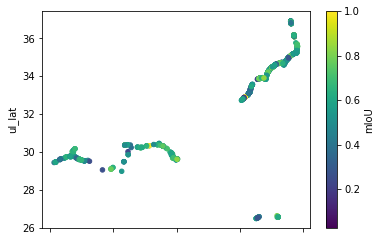

In [10]:
#plot
ax1 = doodlecsv.plot.scatter(x='ul_lon',y='ul_lat',c='mIoU', colormap='viridis')

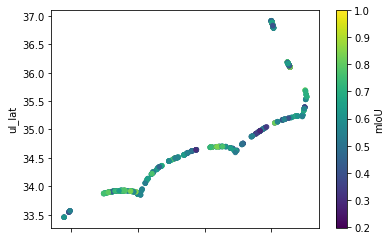

In [11]:
#florence, NC capes

flo = doodlecsv.loc[doodlecsv.storm_id == 'florence']

ax2 = flo.plot.scatter(x='ul_lon',y='ul_lat',c='mIoU', colormap='viridis')

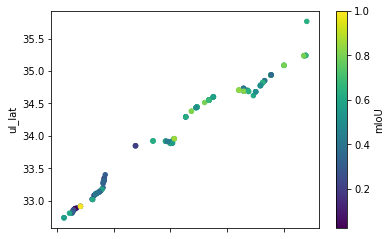

In [12]:
#Isaias, NC capes

Is = doodlecsv.loc[doodlecsv.storm_id == 'isaias']

ax2 = Is.plot.scatter(x='ul_lon',y='ul_lat',c='mIoU', colormap='viridis')

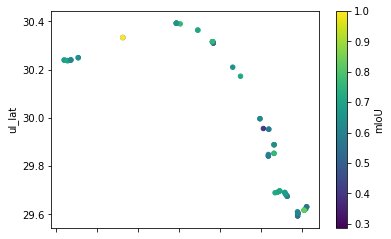

In [13]:
#Michael (florida gulf coast)
Mi = doodlecsv.loc[doodlecsv.storm_id == 'michael']

ax3 = Mi.plot.scatter(x='ul_lon',y='ul_lat',c='mIoU', colormap='viridis')

(-79, -75)

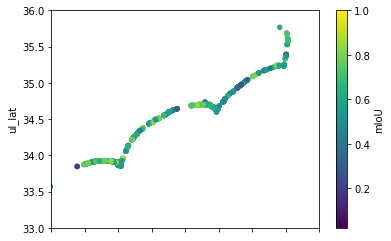

In [14]:
#Florence zoomed in onNC
ax1 = doodlecsv.plot.scatter(x='ul_lon',y='ul_lat',c='mIoU', colormap='viridis')
ax1.set_ylim(33,36)
ax1.set_xlim(-79,-75)

In [15]:
doodlecsv.to_csv('../data/Preds.csv')